# 1. Loading and Preparing the Data
Clone of the repository

In [ ]:
! pip install pandas
! pip install sklearn-pandas
! pip install sklearn

rm: cannot remove 'FairAnnoMI': No such file or directory
Cloning into 'FairAnnoMI'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 125 (delta 50), reused 96 (delta 25), pack-reused 0
Receiving objects: 100% (125/125), 561.30 KiB | 1.33 MiB/s, done.
Resolving deltas: 100% (50/50), done.
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2936 sha256=fa9e7c1fa69f8fc377dc56c29a4e45f8a2e1e9beb7828236a2165c256b4f09a9
  Stored in directory: /root/.cache/pip/wheels/f8/e0/3d/9d0c2020c44a519b9f02ab4fa6d2a4a996c98d79ab2f569fa1
Successfully built sklearn


In [2]:
! pip install ..

Processing ./FairAnnoMI
  Preparing metadata (setup.py) ... done
  Created wheel for fair-annomi: filename=fair_annomi-0.1.0-py3-none-any.whl size=571501 sha256=9ce6b6b0c383d38eb5c88ce379e5a9440cf6be7ed9ca59393dfdd4fd0c16c2e1
  Stored in directory: /tmp/pip-ephem-wheel-cache-m2wwcsw0/wheels/1c/25/bc/db8ff3ff70ab1d7278c4ba607cff9377388de1c4897e690665
Successfully built fair-annomi


The class AnnoMI handles the cleaning, remapping of the topics, as well as the cleaning and
abbreviations removal of the utterances text. First, we import the necessaries libraries

In [1]:
import os
import json
import pickle
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from fair_annomi.data_processing.dataset import AnnoMI

The method `prepare_new_dataset` transforms the old AnnoMI in the new one (topic remapped and
utterances text cleaned).

The method `train_test_split` splits the data in train and test (as Pandas dataframes) such
that the topics and the `target_cols` (parameter that represents the list of columns used as
targets for prediction, default = ['client_talk_type', 'main_therapist_behaviour']) are
perfectly distributed in the train and test sets according to the selected `test_size`
(default=0.2  *20%*)

**PARAMETERS**

In [2]:
unprocessed = False  # if True uses unprocessed dataset (i.e., the utterance text is not cleaned) otherwise the processed dataset
test_size = 0.2  # 20%
min_tokens = 5
relevance_label_field = "mi_quality"

In [3]:
client_col = "client_talk_type"
therapist_col = "main_therapist_behaviour"

In [4]:
ami = AnnoMI()
dataset = ami.unprocessed_dataset() if unprocessed else ami.processed_dataset()

dataset['token_len'] = dataset['utterance_text'].str.strip().str.split(' ').apply(len)
dataset = dataset[(dataset.token_len >= min_tokens)].reset_index(drop=True)

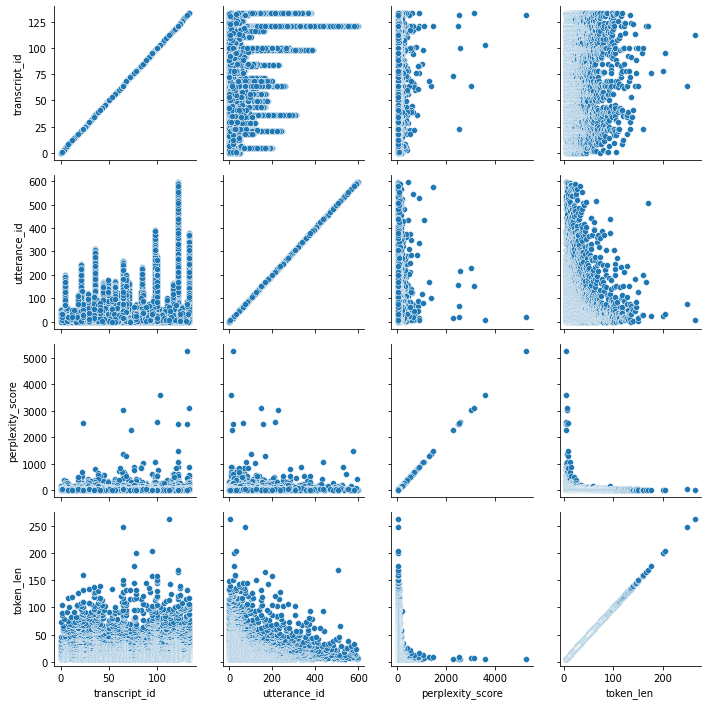

In [5]:
g = sns.PairGrid(dataset.sort_values('token_len'))
g.map(sns.scatterplot)

In [6]:
dataset.shape

(6310, 13)

In [9]:
if relevance_label_field == 'mi_quality':
    topic_mi_quality_gby = dataset.groupby(['topic', 'mi_quality']).count()
    dataset = dataset[
        dataset.topic.isin(list(filter(
            lambda x: 'high' in topic_mi_quality_gby.loc[x].index and 'low' in topic_mi_quality_gby.loc[x].index,
            dataset['topic'].unique()
        )))
    ].reset_index(drop=True)
dataset.shape

(3948, 13)

In [10]:
dataset.mi_quality = dataset.mi_quality.map({'high': 1, 'low': 0})

In [11]:
count_topic_miq = dataset.groupby(['topic', 'mi_quality']).count()[['token_len']]
count_topic_miq = count_topic_miq / len(dataset) * 100
count_topic_miq = count_topic_miq.applymap(lambda x: f'{x:.2f}%').reset_index()
count_topic_miq.rename(columns={'token_len': '', 'topic': 'Topic', 'mi_quality': 'MI Quality'}, inplace=True)
count_topic_miq.pivot('Topic', 'MI Quality', '').to_latex(f'topic_distribution_over_topics.tex')

/tmp/ipykernel_598/3492405991.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  count_topic_miq.pivot('Topic', 'MI Quality', '').to_latex(f'topic_distribution_over_topics.tex')


In [12]:
only_therapist_mask = dataset[client_col].isna()

client_dataset = dataset[~only_therapist_mask]
client_dataset = client_dataset.drop(therapist_col, axis=1)

therapist_dataset = dataset[only_therapist_mask]
therapist_dataset = therapist_dataset.drop(client_col, axis=1)

Add ids to the query (topic) and document (utterance_text) fields

In [13]:
unique_topics = therapist_dataset.topic.unique()
topics_map = dict(zip(unique_topics, range(1, len(unique_topics) + 1)))

unique_documents = therapist_dataset.utterance_text.unique()
documents_map = dict(zip(unique_documents, range(1, len(unique_documents) + 1)))

therapist_dataset['topic_id'] = therapist_dataset.topic.map(topics_map)
therapist_dataset['utterance_text_id'] = therapist_dataset.utterance_text.map(documents_map)

with open('topics_map.json', 'w') as f:
    json.dump(topics_map, f, indent=4)
    
with open('documents_map.json', 'w') as f:
    json.dump(documents_map, f, indent=4)

Split data in train and test, separately for client and therapist

In [14]:
client_train, client_test, client_encoder = ami.train_test_split_target_topic_distributed(client_dataset, target_col=client_col, test_size=test_size, encode_target=True)
client_encoder.classes_

array(['change', 'neutral', 'sustain'], dtype=object)

In [15]:
therapist_train, therapist_test, therapist_encoder = ami.train_test_split_target_topic_distributed(therapist_dataset, target_col=therapist_col, test_size=test_size, encode_target=True)
therapist_encoder.classes_

array(['other', 'question', 'reflection', 'therapist_input'], dtype=object)

Transform text data to TensorFlow ELWC format (Example with Context). It is done by creating a similar JSON stucture and using a script to convert from JSON to ELWC.

In [16]:
def df_to_json_dict(df,
                    text_field='utterance_text',
                    query_field='topic',
                    relevance_field='mi_quality',
                    query_id_field='topic_id',
                    document_id_field='utterance_text_id'):
    out = {'rankingProblems': []}
    documents, queries = [], []
    for query, query_df in df.groupby(query_field):
        out['rankingProblems'].append(
            {
                'queryText': query,
                'documents': []
            }
        )
        
        for _, row in query_df.iterrows():
            document = row[text_field]
            query_id = row[query_id_field]
            document_id = row[document_id_field]
            
            out['rankingProblems'][-1]['documents'].append(
                {
                    'relevance': row[relevance_field],
                    'docText': document,
                    'query_id': query_id,
                    'document_id': document_id
                }
            )
    return out

Download BERT

In [17]:
!mkdir -p /tmp/tfrbert
!wget "https://storage.googleapis.com/cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12.tar.gz" -P "/tmp/tfrbert"
!mkdir -p /tmp/tfrbert/uncased_L-12_H-768_A-12
!tar -xvf /tmp/tfrbert/uncased_L-12_H-768_A-12.tar.gz --strip-components 3 -C "/tmp/tfrbert/uncased_L-12_H-768_A-12/"

--2023-01-19 13:51:23--  https://storage.googleapis.com/cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.62.128, 172.253.115.128, 172.253.63.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.62.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 405351189 (387M) [application/octet-stream]
Saving to: ‘/tmp/tfrbert/uncased_L-12_H-768_A-12.tar.gz.1’

uncased_L-12_H-768_ 100%[===================>] 386.57M   141MB/s    in 2.7s    

2023-01-19 13:51:26 (141 MB/s) - ‘/tmp/tfrbert/uncased_L-12_H-768_A-12.tar.gz.1’ saved [405351189/405351189]

tmp/temp_dir/raw/vocab.txt
tmp/temp_dir/raw/bert_model.ckpt.index
tmp/temp_dir/raw/bert_model.ckpt.data-00000-of-00001
tmp/temp_dir/raw/bert_config.json


TFRBert parameters

In [18]:
BERT_DIR = "/tmp/tfrbert/uncased_L-12_H-768_A-12"
sequence_length = 128
vocab_file = '/tmp/tfrbert/uncased_L-12_H-768_A-12/vocab.txt'
do_lower_case = True
list_size=12

train_steps = 100

In [21]:
! pip install tensorflow_ranking
! pip install tf-models-official

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 4.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 94.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 98.5 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 74.2 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: tensorboard
    Found existing

## TFRBert Utilities
1.   TFRBertRankingNetwork
2.   TFRBertUtil
3.   TFRBertUtilJSON

In [19]:
import tensorflow as tf
import tensorflow_ranking as tfr

from official.modeling import activations
from official.nlp import optimization
from official.nlp.tools import tokenization
from official.nlp.configs import encoders
from official.nlp.modeling import networks as tfmodel_networks
from tensorflow_ranking.python.keras import network as tfrkeras_network
from tensorflow_serving.apis import input_pb2


class TFRBertUtil(object):
  """Class that defines a set of utility functions for Bert."""

  def __init__(self,
               bert_config_file,
               bert_init_ckpt,
               bert_max_seq_length,
               bert_vocab_file=None,
               do_lower_case=None):
    """Constructor.
    Args:
      bert_config_file: (string) path to Bert configuration file.
      bert_init_ckpt: (string)  path to pretrained Bert checkpoint.
      bert_max_seq_length: (int) maximum input sequence length (#words) after
        WordPiece tokenization. Sequences longer than this will be truncated,
        and shorter than this will be padded.
      bert_vocab_file (optional): (string) path to Bert vocabulary file.
      do_lower_case (optional): (bool) whether to lower case the input text.
        This should be aligned with the `vocab_file`.
    """
    self._bert_config_file = bert_config_file
    self._bert_init_ckpt = bert_init_ckpt
    self._bert_max_seq_length = bert_max_seq_length

    self._tokenizer = None
    if bert_vocab_file is not None and do_lower_case is not None:
      self._tokenizer = tokenization.FullTokenizer(
          vocab_file=bert_vocab_file, do_lower_case=do_lower_case)

  def create_optimizer(self,
                       init_lr,
                       train_steps,
                       warmup_steps,
                       optimizer_type="adamw"):
    """Creates an optimizer for TFR-BERT.
    Args:
      init_lr: (float) the init learning rate.
      train_steps: (int) the number of train steps.
      warmup_steps: (int) if global_step < num_warmup_steps, the learning rate
        will be `global_step / num_warmup_steps * init_lr`. See more details in
        the `tensorflow_models.official.nlp.optimization.py` file.
      optimizer_type: (string) Optimizer type, can either be `adamw` or `lamb`.
        Default to be the `adamw` (AdamWeightDecay). See more details in the
        `tensorflow_models.official.nlp.optimization.py` file.
    Returns:
      The optimizer training op.
    """

    return optimization.create_optimizer(
        init_lr=init_lr,
        num_train_steps=train_steps,
        num_warmup_steps=warmup_steps,
        optimizer_type=optimizer_type)

  def get_warm_start_settings(self, exclude):
    """Defines warm-start settings for the TFRBert ranking estimator.
    Our TFRBert ranking models will warm-start from a pre-trained Bert model.
    Here, we define the warm-start setting by excluding non-Bert parameters.
    Args:
      exclude: (string) Variable to exclude from the warm-start settings.
    Returns:
      (`tf.estimator.WarmStartSettings`) the warm-start setting for the TFRBert
      ranking estimator.
    """
    # A regular expression to exclude the variables starting with the passed-in
    # `exclude` parameter. Variables from the downloaded Bert checkpoints often
    # start with `transformer`, `pooler`, `embeddings` and etc., whereas other
    # variables specifically to the TFRBertRankingNetwork start with the `name`
    # we passed to the `TFRBertRankingNetwork` constructor. When defining the
    # warm-start settings, we exclude those non-Bert variables.
    vars_to_warm_start = "^(?!{exclude}).*$".format(exclude=exclude)
    return tf.estimator.WarmStartSettings(
        ckpt_to_initialize_from=self._bert_init_ckpt,
        vars_to_warm_start=vars_to_warm_start)

  def _truncate_seq_pair(self, tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""
    # This is a simple heuristic which truncates the longer sequence until
    # their combined length is no longer than max_length.
    # This makes more sense than truncating with an equal percentage of tokens
    # from each, since if a sequence is very short then each token that's
    # truncated likely contains more information than a longer sequence.
    assert max_length > 0
    assert isinstance(max_length, int)
    if len(tokens_a) + len(tokens_b) > max_length:
      # Truncation is needed.
      if (len(tokens_a) >= max_length - max_length // 2 and
          len(tokens_b) >= max_length // 2):
        # Truncate both sequences until they have almost equal lengths and the
        # combined length is no longer than max_length
        del tokens_a[max_length - max_length // 2:]
        del tokens_b[max_length // 2:]
      elif len(tokens_a) > len(tokens_b):
        # Only truncating tokens_a would suffice
        del tokens_a[max_length - len(tokens_b):]
      else:
        # Only truncating tokens_b would suffice
        del tokens_b[max_length - len(tokens_a):]

  def _to_bert_ids(self, sent_a, sent_b=None):
    """Converts a sentence pair (sent_a, sent_b) to related Bert ids.
    This function is mostly adopted from run_classifier.convert_single_example
    in bert/run_classifier.py.
    Args:
      sent_a: (str) the raw text of the first sentence.
      sent_b: (str) the raw text of the second sentence.
    Returns:
      A tuple (`input_ids`, `input_masks`, `segment_ids`) for Bert finetuning.
    """

    if self._tokenizer is None:
      raise ValueError("Please pass both `vocab_file` and `do_lower_case` in "
                       "the BertUtil constructor to build a Bert tokenizer!")

    if sent_a is None:
      raise ValueError("`sent_a` cannot be None!")

    tokens_a = self._tokenizer.tokenize(sent_a)
    tokens_b = None if not sent_b else self._tokenizer.tokenize(sent_b)

    if tokens_b:
      # Modifies `tokens_a` and `tokens_b` in place so that the total length is
      # less than the specified length. Since the final sequence will be
      # [CLS] `tokens_a` [SEP] `tokens_b` [SEP], thus, we use `- 3`.
      self._truncate_seq_pair(tokens_a, tokens_b, self._bert_max_seq_length - 3)
    else:
      # Account for [CLS] and [SEP] with "- 2".  Since there is only one
      # sentence, we don't need to account for the second [SEP].
      self._truncate_seq_pair(tokens_a, [], self._bert_max_seq_length - 2)

    # The convention in BERT for sequence pairs:
    #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
    #  type_ids: 0     0  0    0    0     0       0 0     1  1  1  1   1 1
    #
    # The `type_ids` (aka. `segment_ids`) are used to indicate whether this is
    # the first or the second sequence. The embedding vectors for `type=0` and
    # `type=1` were learned during pre-training and are added to the wordpiece
    # embedding vector (and position vector). This is not *strictly* necessary
    # since the [SEP] token unambiguously separates the sequences, but it makes
    # it easier for the model to learn the concept of sequences.
    #
    # For classification tasks, the first vector (corresponding to [CLS]) is
    # used as the "sentence vector". Note that this only makes sense because
    # the entire model is fine-tuned.
    #
    # When there is only one sentence given, the sequence pair would be:
    #  tokens:   [CLS] is this jack ##son ##ville ? [SEP]
    #  type_ids: 0     0  0    0    0     0       0 0

    tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
    segment_ids = [0] + [0] * len(tokens_a) + [0]
    if tokens_b:
      tokens += tokens_b + ["[SEP]"]
      segment_ids += [1] * len(tokens_b) + [1]
    input_ids = self._tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    if len(input_ids) < self._bert_max_seq_length:
      padding_len = self._bert_max_seq_length - len(input_ids)
      input_ids.extend([0] * padding_len)
      input_mask.extend([0] * padding_len)
      segment_ids.extend([0] * padding_len)

    assert len(input_ids) == self._bert_max_seq_length
    assert len(input_mask) == self._bert_max_seq_length
    assert len(segment_ids) == self._bert_max_seq_length

    return input_ids, input_mask, segment_ids

  def convert_to_elwc(self, context, examples, query_ids, document_ids, labels, label_name):
    """Converts a <context, example list> pair to an ELWC example.
    Args:
      context: (str) raw text for a context (aka. query).
      examples: (list) raw texts for a list of examples (aka. documents).
      labels: (list) a list of labels (int) for the `examples`.
      label_name: (str) name of the label in the ELWC example.
    Returns:
      A tensorflow.serving.ExampleListWithContext example containing the
      `input_ids`, `input_masks`, `segment_ids` and `label_id` fields.
    """
    if len(examples) != len(labels):
      raise ValueError("`examples` and `labels` should have the same size!")

    elwc = input_pb2.ExampleListWithContext()
    for example, label, query_id, document_id in zip(examples, labels, query_ids, document_ids):
      (input_ids, input_mask, segment_ids) = self._to_bert_ids(context, example)

      feature = {
          "input_ids":
              tf.train.Feature(int64_list=tf.train.Int64List(value=input_ids)),
          "input_mask":
              tf.train.Feature(int64_list=tf.train.Int64List(value=input_mask)),
          "segment_ids":
              tf.train.Feature(
                  int64_list=tf.train.Int64List(value=segment_ids)),
          label_name:
              tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
          'query_id':
              tf.train.Feature(int64_list=tf.train.Int64List(value=[query_id])),
          'document_id':
              tf.train.Feature(int64_list=tf.train.Int64List(value=[document_id]))
      }
      tf_example = tf.train.Example(features=tf.train.Features(feature=feature))
      elwc.examples.append(tf_example)

    return elwc


class TFRBertUtilJSON(object):

    def __init__(self, TFRBertUtil):
        self.TFRBertUtilHelper = TFRBertUtil        

    # Helper function for making toy data
    # Out: Returns toy ranking data data in ELWC format
    def mkToyRankingRecord(self):
        query = "Where can you buy cat food?"
        documents = ["The pet food store", "Bicycles have two wheels", "The grocery store", "Cats eat cat food"]
        labels = [3, 1, 3, 2]
        label_name = "relevance"
        elwcOut = self.TFRBertUtilHelper.convert_to_elwc(query, documents, labels, label_name)

        # (DEBUG) Examine the structure of the ELWC records for tfr-bert
        # print(elwcOut)

        return elwcOut


    # Conversion function for converting easily-read JSON into TFR-Bert's ELWC format, and exporting to file
    # In: filename of JSON with ranking problems (see example json files for output)
    # Out: creates TFrecord output file, also returns list of ranking problems read in from JSON
    def convert_json_to_elwc_export(self, filenameJsonIn, filenameTFRecordOut):
        # Step 1: Convert JSON to ELWC
        (listToRank, listJsonRaw) = self.convert_json_to_elwc(filenameJsonIn)

        # Step 2: Save ELWC to file
        try:
            with tf.io.TFRecordWriter(filenameTFRecordOut) as writer:
                for example in listToRank * 10:
                    writer.write(example.SerializeToString())
        except:
            print("convert_json_to_elwc_export: error writing ELWC file (filename = " + filenameTFRecordOut + ")")
            exit(1)
        
        # Step 3: Also return ranking problem in JSON format, for use in scoring/exporting
        return listJsonRaw


    # Conversion function for converting easily-read JSON into TFR-Bert's ELWC format
    # In: JSON filename
    # Out: List of ELWC records, list of original JSON records
    def convert_json_to_elwc(self, filenameJsonIn):
        # Step 1: Load JSON file
        listToRankELWC = []
        listJsonRaw = []
        try:
            with open(filenameJsonIn) as json_file:
                # Load whole JSON file
                data = json.load(json_file)

                # Parse each record
                for rankingProblem in data['rankingProblems']:
                    labels = []
                    docTexts = []
                    query_ids = []
                    document_ids = []

                    queryText = rankingProblem['queryText']
                    documents = rankingProblem['documents']
                    for document in documents:
                        docText = document['docText']
                        docRel = document['relevance']      # Convert to int?
                        qid = document['query_id']
                        doc_id = document['document_id'] 

                        labels.append(docRel)
                        docTexts.append(docText)
                        query_ids.append(qid)
                        document_ids.append(doc_id)

                    # Step 1A: Convert this record to ELWC
                    elwcOut = self.TFRBertUtilHelper.convert_to_elwc(queryText, docTexts, query_ids, document_ids, labels, label_name="relevance")
                    listToRankELWC.append(elwcOut)
                    # Step 1B: Also store the raw record, for exporting output in the same format it was read in
                    listJsonRaw.append(rankingProblem)

        except Exception as e:
            print(e)
            print("convert_json_to_elwc_export: error loading JSON file (filename = " + filenameJsonIn + ")")
            exit(1)

        return (listToRankELWC, listJsonRaw)

2023-01-19 13:51:31.198287: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 13:51:31.983777: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-01-19 13:51:31.983863: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-01-19 13:51:31.983873: W tensorfl

## Hands on TFRBert

In [20]:
def create_tfrbert_util_with_vocab(bertMaxSeqLength, bertVocabFile, do_lower_case=True):
    # bertMaxSeqLength typically 128, 256, 512
    return TFRBertUtil(
            bert_config_file=None,
            bert_init_ckpt=None,
            bert_max_seq_length=bertMaxSeqLength,
            bert_vocab_file=bertVocabFile,
            do_lower_case=do_lower_case)
    
bert_helper = create_tfrbert_util_with_vocab(sequence_length, vocab_file, do_lower_case)
bert_helper_json = TFRBertUtilJSON(bert_helper)

In [21]:
for split_set, split_type in zip([therapist_train, therapist_test], ["therapist_train", "therapist_test"]):
    json_dict = df_to_json_dict(split_set, relevance_field=relevance_label_field)
    json_file = relevance_label_field + '_' + split_type + '.json'
    with open(json_file, 'w') as f:
        json.dump(json_dict, f)
    bert_helper_json.convert_json_to_elwc_export(json_file, relevance_label_field + '_' + split_type + '.tfrecord')

Prepare the TFRBert Config and Data Config

In [22]:
from tensorflow_ranking.extension.premade import tfrbert_task

train_data_config = tfrbert_task.TFRBertDataConfig(
    input_path=relevance_label_field + '_' + "therapist_train.tfrecord",
    is_training=True,
    global_batch_size=8,
    list_size=list_size,
    dataset_fn='tfrecord',
    seq_length=sequence_length,
    read_query_id=True,
    read_document_id=True)

validation_data_config = tfrbert_task.TFRBertDataConfig(
    input_path=relevance_label_field + '_' + "therapist_test.tfrecord",
    is_training=False,
    global_batch_size=8,
    list_size=list_size,
    dataset_fn='tfrecord',
    seq_length=sequence_length,
    read_query_id=True,
    read_document_id=True)

In [23]:
# Set up task config
task_config = tfrbert_task.TFRBertConfig(
    init_checkpoint=os.path.join(BERT_DIR, 'bert_model.ckpt'),
    train_data=train_data_config,
    validation_data=validation_data_config,
    model=tfrbert_task.TFRBertModelConfig(
        encoder=encoders.EncoderConfig(
            bert=encoders.BertEncoderConfig(num_layers=12))),
    aggregated_metrics=True,
    output_preds=True
)

# Set up TFRBertTask
task = tfrbert_task.TFRBertTask(
    task_config,
    label_spec=(
        "relevance",
        tf.io.FixedLenFeature(shape=(1,), dtype=tf.int64, default_value=-1)
    ),
    dataset_fn=tf.data.TFRecordDataset,
    logging_dir='/tmp/model_dir'
)

## Train Step

In [24]:
def output_preds(aggregated_logs, data_type="test"):
    import time
    flattened_aggregated_logs = {
        key: np.reshape(np.concatenate(logs, axis=0), -1)
        for key, logs in aggregated_logs.items()
    }

    # Output predictions, labels, query ids and document ids to a csv file.
    output_path = os.path.join(os.pardir, 'predictions', 'tfrbert', f'{data_type}_{relevance_label_field}_prediction_{time.strftime("%s", time.localtime())}.csv')
    flattened_output_logs = {
        key: flattened_aggregated_logs[key]
        for key in list(task._get_output_feature_names()) + ['prediction', 'label']
    }
    task._write_as_csv(flattened_output_logs, output_path)
    return output_path

In [25]:
metrics = task.build_metrics()
model = task.build_model()
task.initialize(model)
train_dataset = task.build_inputs(task_config.train_data)
train_iterator = iter(train_dataset)
optimizer = tf.keras.optimizers.Adam(lr=1e-6)

best_step = None
best_metric = -1
patience = 3
for train_step in range(train_steps):
    train_step_data = next(train_iterator)
    task.train_step(train_step_data, model, optimizer, metrics=metrics)
    train_metrics = {m.name: m.result().numpy() for m in metrics}
    print("Training metrics for epoch: " + str(train_step) + " ", train_metrics)
    if train_metrics['NDCG@10'] > best_metric:
        best_step = train_step
        best_metric = train_metrics['NDCG@10']
    elif train_step > best_step + patience:
        print(best_step, best_metric)
        break

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
/usr/local/lib/python3.9/dist-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['document_id', 'query_id'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


Training metrics for epoch: 0  {'MAP': 0.8795061, 'NDCG@1': 0.875, 'NDCG@5': 0.8482517, 'NDCG@10': 0.8966707, 'MRR@1': 0.875, 'MRR@5': 0.9375, 'MRR@10': 0.9375}
Training metrics for epoch: 1  {'MAP': 0.8558681, 'NDCG@1': 0.875, 'NDCG@5': 0.817548, 'NDCG@10': 0.8871325, 'MRR@1': 0.875, 'MRR@5': 0.9270834, 'MRR@10': 0.9270834}
Training metrics for epoch: 2  {'MAP': 0.8789794, 'NDCG@1': 0.875, 'NDCG@5': 0.8492314, 'NDCG@10': 0.8980453, 'MRR@1': 0.875, 'MRR@5': 0.9305556, 'MRR@10': 0.9305556}
Training metrics for epoch: 3  {'MAP': 0.8442297, 'NDCG@1': 0.84375, 'NDCG@5': 0.80852544, 'NDCG@10': 0.87117064, 'MRR@1': 0.84375, 'MRR@5': 0.9166667, 'MRR@10': 0.9166667}
Training metrics for epoch: 4  {'MAP': 0.83711845, 'NDCG@1': 0.875, 'NDCG@5': 0.80356634, 'NDCG@10': 0.86611396, 'MRR@1': 0.875, 'MRR@5': 0.9333334, 'MRR@10': 0.9333334}
Training metrics for epoch: 5  {'MAP': 0.8351514, 'NDCG@1': 0.875, 'NDCG@5': 0.7978619, 'NDCG@10': 0.8679655, 'MRR@1': 0.875, 'MRR@5': 0.9305556, 'MRR@10': 0.93055

In [26]:
test_dataset = task.build_inputs(task_config.validation_data)
test_iterator = iter(test_dataset)
log_state = None
for test_step_data in test_iterator:
    test_logs = task.validation_step(test_step_data, model, metrics=metrics)
    log_state = task.aggregate_logs(state=log_state, step_outputs=test_logs)
    vali_metrics = {m.name: m.result().numpy() for m in metrics}
    print("Validation metrics for batch data: " + str(vali_metrics))
pred_path = output_preds(log_state, "test")

Validation metrics for batch data: {'MAP': 0.84231406, 'NDCG@1': 0.859375, 'NDCG@5': 0.8127008, 'NDCG@10': 0.86925554, 'MRR@1': 0.859375, 'MRR@5': 0.921875, 'MRR@10': 0.921875}
Validation metrics for batch data: {'MAP': 0.8410628, 'NDCG@1': 0.8472222, 'NDCG@5': 0.81567127, 'NDCG@10': 0.8663231, 'MRR@1': 0.8472222, 'MRR@5': 0.9166667, 'MRR@10': 0.9166667}
Validation metrics for batch data: {'MAP': 0.8400618, 'NDCG@1': 0.8375, 'NDCG@5': 0.81804764, 'NDCG@10': 0.86397713, 'MRR@1': 0.8375, 'MRR@5': 0.9125, 'MRR@10': 0.9125}
Validation metrics for batch data: {'MAP': 0.83924276, 'NDCG@1': 0.82954544, 'NDCG@5': 0.8199919, 'NDCG@10': 0.8620577, 'MRR@1': 0.82954544, 'MRR@5': 0.90909094, 'MRR@10': 0.90909094}
Validation metrics for batch data: {'MAP': 0.8385603, 'NDCG@1': 0.8229167, 'NDCG@5': 0.8216121, 'NDCG@10': 0.86045814, 'MRR@1': 0.8229167, 'MRR@5': 0.90625, 'MRR@10': 0.90625}
Validation metrics for batch data: {'MAP': 0.8379828, 'NDCG@1': 0.8173077, 'NDCG@5': 0.8229831, 'NDCG@10': 0.85910

In [31]:
prdf = pd.read_csv(pred_path)

result_df = therapist_test.join(
    prdf[prdf.columns[~prdf.columns.isin(['label'])]].set_index(['query_id', 'document_id']),
    on=['topic_id', 'utterance_text_id']
)
result_df.drop_duplicates(subset=['topic_id', 'utterance_text_id']).to_csv(
    os.path.join(os.pardir, 'predictions', 'tfrbert', 'bert_mi_quality_predictions.csv'), index=None
)